## Integrating a simple harmonic oscillator and trying to fit for the spring constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline

In [2]:
def leapfrog(x0, v0, phi_grad, dt, nsteps, *args, **kwargs):
    #function that takes initial conditions that takes us to the next position 
    v0_5 = v0 + phi_grad(x0, *args, **kwargs)*dt/2.
    x = [] #np.zeros(nsteps+1)
    v = [] #np.zeros(nsteps+1)
    t = [] #np.zeros(nsteps+1)
    x.append(x0)
    v.append(v0)
    t.append(0.)
    #x[0] = x0
    #v[0] = v0
    #t[0] = 0
    for i in range(nsteps):
        x.append(x[i] + dt*v0_5)
        a      = -phi_grad(x[i+1], *args, **kwargs)
        v.append(v0_5 + a*dt/2)
        v0_5   = v0_5 + a*dt
        t.append(t[i] + dt)
        #x[i+1] = x[i] + dt*v0_5
        #a      = -phi_grad(x[i+1], *args, **kwargs)
        #v[i+1] = v0_5 + a*dt/2
        #v0_5   = v0_5 + a*dt
        #t[i+1] = t[i] + dt
    return np.array(x), np.array(v), np.array(t)

In [3]:
def phi_grad(x, k=1):
    return k*x

In [4]:
def genData(x, v, t, npoints, std_noise):
    print(len(x))
    randind = np.random.choice(len(x), npoints, replace=False)
    noise_x = np.random.normal(0, std_noise, len(randind))
    noise_v = np.random.normal(0, std_noise, len(randind))
    return noise_x + x[randind], noise_v + v[randind], t[randind]

In [5]:
def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0 = theta
    x_obs, v_obs, t_obs, sigma_x, sigma_v = data
    nsteps_model = int(np.max(t_obs)/dt_model) + 10 #hack, add 10 for cusion 
    x, v, t = leapfrog(x0, v0, phi_grad, dt_model, nsteps_model, k=k)
    #interpolate between values and sample at observed t
    order = 3
    #v_interp = InterpolatedUnivariateSpline(t, v, k=order)
    #x_interp = InterpolatedUnivariateSpline(t, x, k=order)

    close_ind = []
    for to in t_obs:
        dt = np.abs(t - to)
        close_ind.append(np.where(dt == np.min(dt))[0])
    close_ind = np.array(close_ind).T
    #print(close_ind)
    #plt.plot(t, v_interp(t), c='C0')
    #plt.plot(t_true, v_true, c='black')
    #plt.plot(t, x_interp(t), c='C1')
    #plt.plot(t_true, x_true, c='black')
    #print(v[close_ind], v_obs, x[close_ind], x_obs)
    chi2 += -(v[close_ind] - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x[close_ind] - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

In [6]:
x0_true   = 0
v0_true   = 100
k_true    = 10

dt        = 0.1
dt_model  = 0.1 #rate to sample the likelihood model to interpolate to t_obs
nmodelpoints = 30

nobspoints   = 10
std_noise = 1.0

assert nmodelpoints > nobspoints, 'The number of model points must be greater than the number of observed points'

In [7]:
#generate true values and noisify them
x_true, v_true, t_true = leapfrog(x0_true, v0_true, phi_grad, dt, nmodelpoints, k=k_true)
x_obs, v_obs, t_obs = genData(x_true, v_true, t_true, nobspoints, std_noise)

31


In [8]:
data   = [x_obs, v_obs, t_obs, std_noise, std_noise]
p_true = [k_true, x0_true, v0_true]
p0     = [k_true*1.1, x0_true*1.1, v0_true*1.1]
args   = (data, dt_model)

<Container object of 3 artists>

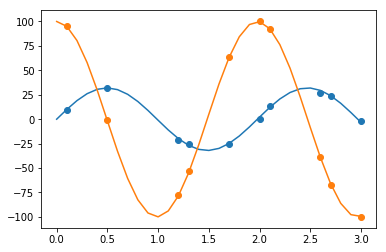

In [9]:
plt.plot(t_true, x_true, c='C0')
plt.plot(t_true, v_true, c='C1')
plt.errorbar(t_obs, x_obs, yerr=std_noise, fmt='o', color='C0')
plt.errorbar(t_obs, v_obs, yerr=std_noise, fmt='o', color='C1')

In [10]:
ln_likelihood(p0, data, dt_model)

-2337.5203586225698

In [11]:
#%%timeit
#res = so.minimize(lambda *args : -ln_likelihood(*args),
#                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [12]:
res = so.minimize(lambda *args : -ln_likelihood(*args),
                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [13]:
res

   direc: array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.04836289,  0.47872407, -0.30372999]])
     fun: 12.977935886589234
 message: 'Optimization terminated successfully.'
    nfev: 159
     nit: 5
  status: 0
 success: True
       x: array([  10.01772744,   -0.12359749,  100.00420425])

In [14]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(res.x[0], res.x[1], res.x[2]))


The true values are: k = 10.00, x0 = 0.00, v0 = 100.00
The optimized values are: k = 10.02, x0 = -0.12, v0 = 100.00


Text(0.5,1,'Best fit k, x0, v0 from Optimization')

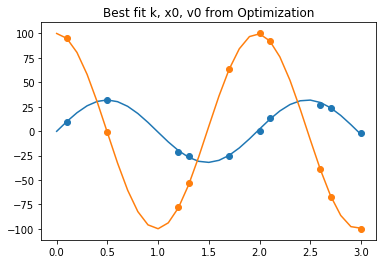

In [15]:
#plot best fit from optimization 
x, v, t = leapfrog(res.x[1], res.x[2], phi_grad, dt_model, nmodelpoints, k=res.x[0])
plt.plot(t, x, c='C0')
plt.plot(t, v, c='C1')
plt.errorbar(t_obs, x_obs, yerr=std_noise, fmt='o', color='C0')
plt.errorbar(t_obs, v_obs, yerr=std_noise, fmt='o', color='C1')
plt.title('Best fit k, x0, v0 from Optimization')

In [16]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  

In [17]:
def nll(*args):
    return -ln_likelihood(*args)

In [18]:
grad_ln_like = grad(nll)

In [19]:
grad_ln_like(p0, data, dt_model)

[array(3724.213918118009), array(431.6689877685877), array(76.05209184963115)]

In [20]:
#%%timeit
#args = (data, dt_model) 
#res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [21]:
args = (data, dt_model) 
res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [22]:
res

      fun: 12.97793582082697
 hess_inv: array([[ 0.00108178, -0.00902304,  0.00566838],
       [-0.00902304,  0.09613078, -0.06379587],
       [ 0.00566838, -0.06379587,  0.20314816]])
      jac: array([  5.16144919e-06,   1.21465077e-06,  -3.67591092e-06])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([  10.01772354,   -0.12361411,  100.00423762])